# VAR Baseline for Cambridge UK Weather Forecasting

[Vector autoregression](https://en.wikipedia.org/wiki/Vector_autoregression) (VAR) models generalise the single-variable autoregressive model by capturing the relationships between multivariate time series.  This notebook updates the earlier VAR model from the [baselines notebook](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) with more data, cleaner data and more extensively tuned parameters.

This notebook is being developed on [Google Colab](https://colab.research.google.com), using [statsmodels](https://www.statsmodels.org/) and the [Darts](https://unit8co.github.io/darts/) time series package.  Initially I was most interested in short term temperature forecasts (less than 2 hours) but now mostly produce results up to 24 hours in the future for comparison with earlier [baselines](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb).

See my previous notebooks, web apps etc:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

The linked notebooks, web apps etc contain further details including:
 * data description
 * data cleaning and preparation
 * data exploration

In particular, see the notebooks:
 * [cammet_baselines_2021](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) including persistent, simple exponential smoothing, Holt Winter's exponential smoothing and vector autoregression
 * [gradient_boosting](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/gradient_boosting.ipynb) notebook uses the results of the updated VAR model as the main baseline for model comparison
 * [keras_mlp_fcn_resnet_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
 * [lstm_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb) with stacked LSTMs, bidirectional LSTMs and ConvLSTM1D networks
 * [cnn_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cnn_time_series.ipynb) with Conv1D, multi-head Conv1D, Conv2D and Inception-style models
 * [encoder_decoder](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/encoder_decoder.ipynb) which includes autoencoder with attention, encoder decoder with teacher forcing, transformer with teacher forcing and padding, encoder only with MultiHeadAttention
 * [feature_engineering](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/feature_engineering.ipynb) solar-based and meteorology-based calculated features, rolling stats, tsfeatures, catch22, bivariate features and more
 * [tsfresh_feature_engineering](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb) automated feature engineering and selection for time series analysis of Cambridge UK weather measurements

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

---

## Table of Contents


**TODO** Add internal links before "final" commits

Some sections may get added/deleted during development.

Don't want any broken links, so finish later.


Code Setup
 * darts Installation
 * Library Imports
 * Environment Variables
 * Custom Functions

Data Setup
 * Load Default Features

VAR Models
 * Lag Selection
 * Diagnostics
 * Forecast Error Variance Decomposition

Conclusion
 * What Worked
 * What Failed
 * Future Work

Metadata

## Code Setup

### Install darts Library

Install [darts](https://unit8co.github.io/darts/) because it is currently not available on google colab.  The darts `TimeSeries` class is used in the `get_var_backtest` function and dependent functions like `get_historic_comparison`.

**WARNING**: You may need to restart the google colab runtime after this install.

In [1]:
!pip install "u8darts[notorch]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.2/847.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.8

---

### Load Libraries

Load the required packages:

In [2]:
import re
import sys
import math
import timeit
import warnings
import datetime
import itertools
import subprocess
import pkg_resources

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from itertools import product
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, medianabs
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.utils import check_X_y
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from darts import TimeSeries


# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random

# set seed to make all processes deterministic
seed = 0
random.seed(seed)
np.random.seed(seed)


%matplotlib inline

env: PYTHONHASHSEED=0



### Environment Variables

Set some environment variables:

In [3]:
HORIZON = 48
Y_COL   = 'y_des' # 'y_des_fft' 'y_res' 'y'
CORE_FEATS = [Y_COL, 'dew.point_des', 'humidity', 'pressure']
FUT_FEATS  = ['irradiance', 'za_rad', 'azimuth_cos']

DAY  = 24 * 60 * 60
YEAR = 365.2425 * DAY

DAILY_OBS  = 48
YEARLY_OBS = int(365.2425 * DAILY_OBS)  # annual observations
DAY_SECS_STEP = int(DAY / DAILY_OBS)

VALID_YEAR = 2021
TEST_YEAR  = 2022


### Custom Functions

Next, define some utility functions:
  * `_check_obs_preds_lens_eq`
  * `rmse_`
  * `mse_`
  * `mae_`
  * `load_features_file`
  * `load_train_valid_test_features`
  * `drop_correlated_cols`
  * `plot_observation_examples`
  * `sanity_check_df_rows_cols_labels`
  * `sanity_check_before_after_dfs`
  * `compare_train_valid_test_sanity_dfs`
  * `sanity_check_train_valid_test`
  * `print_train_valid_test_shapes`
  * `plot_feature_history_single_df`
  * `plot_feature_history`
  * `plot_feature_history_separately`
  * `check_high_low_thresholds`
  * `print_df_summary`
  * `get_approx_overlap`
  * `expand_grid`
  * `keep_key`
  * `get_historic_comparison`
  * `summarise_historic_comparison`
  * `print_rmse_mae`
  * `_plot_xy_for_label`
  * `plot_multistep_obs_vs_preds`
  * `plot_multistep_obs_vs_mean_preds_by_step`
  * `plot_multistep_obs_preds_dists`
  * `plot_multistep_residuals`
  * `plot_multistep_residuals_dist`
  * `plot_multistep_residuals_vs_predicted`
  * `se_`
  * `metric_ci_vals`
  * `plot_horizon_metrics`
  * `plot_horizon_metrics_boxplots`
  * `plot_multistep_diagnostics`


In [4]:


def _check_obs_preds_lens_eq(obs, preds):
    obs_preds_lens_eq = 1

    if len(obs) != len(preds):
        print("obs:  ", len(obs))
        print("preds:", len(preds))
        obs_preds_lens_eq = 0

    return obs_preds_lens_eq


def rmse_(obs, preds):
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.sqrt(np.mean((obs - preds) ** 2))


def mse_(obs, preds):
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean((obs - preds) ** 2)


def mae_(obs, preds):
    "mean absolute error - equivalent to the keras loss function"
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean(np.abs(obs - preds))      # keras loss
        # return np.median(np.abs(obs - preds))  # earlier baselines


def load_features_file(feature_set,
                       data_set,
                       location = 'gdrive',
                       date_str = '.2022.09.20',
                       filex    = '.parquet'):

  if location == 'github':
    base_url = 'https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/features/'
    filex += '?raw=true'
  elif location == 'gdrive':
    base_url = '/content/drive/MyDrive/data/CambridgeTemperatureNotebooks/features/'
  else:
    print("Unsupported 'location' in load_features_file function:")
    print('  location =', location)

  file_str = feature_set + '_' + data_set + date_str + filex
  data_url = base_url + file_str

  df = pd.read_parquet(data_url)

  df.set_index('ds', drop=False, inplace=True)
  df = df[~df.index.duplicated(keep='first')]
  df = df.asfreq(freq='30min')

  return df


def load_train_valid_test_features(feature_set, location='gdrive'):
  train = load_features_file(feature_set, 'train', location)
  valid = load_features_file(feature_set, 'valid', location)
  test  = load_features_file(feature_set, 'test',  location)

  sanity_check_train_valid_test(train, valid, test)

  check_high_low_thresholds(train, 'train '+feature_set)
  check_high_low_thresholds(valid, 'valid '+feature_set)
  check_high_low_thresholds(test,   'test '+feature_set)

  return train, valid, test



def drop_correlated_cols(dataset, threshold=0.95):
  '''Adapted from https://stackoverflow.com/a/44674459/100129'''

  col_corr = set()  # Set of all the names of deleted columns
  corr_matrix = dataset.corr(numeric_only=True).abs()

  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
        if colname in dataset.columns:
          del dataset[colname]

  return dataset


def plot_observation_examples(df, cols, num_plots = 9):
    """Plot 9 sets of observations in 3 * 3 matrix"""

    num_plots_sqrt = int(np.sqrt(num_plots))
    assert num_plots_sqrt ** 2 == num_plots

    days = df.ds.dt.date.sample(n = num_plots).sort_values()
    p_data = [df[df.ds.dt.date.eq(days[i])] for i in range(num_plots)]

    fig, axs = plt.subplots(num_plots_sqrt, num_plots_sqrt, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(num_plots):
        for col in cols:
            axs[i].plot(p_data[i]['ds'], p_data[i][col])
            axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)

    fig.suptitle('Observation examples')
    fig.legend(cols, loc = 'lower center',  ncol = len(cols))

    return None


# TODO Change to operate on single dataframe - More useful function :-)
#      Change as far as possible - merge(), common_cols etc
#      Then write a wrapper to operate on before and after dataframes
#      combine results and calculate differences
def sanity_check_df_rows_cols_labels(before, after,
                                     row_var_cutoff=0.005, col_var_cutoff=0.05,
                                     col_corr_cutoff=0.,
                                     fast=True, verbose=False):
  '''Sanity check dataframes before and after modifications

  WARN: default row_var_cutoff, col_var_cutoff, col_corr_cutoff are fairly arbitrary
        there is some redundancy between these tests

  '''

  print_v = print if verbose else lambda *a, **k: None

  df = pd.DataFrame(columns = ['before', 'after', 'diff'])
  df_labels = []

  label = 'rows'
  # start_time = timeit.default_timer()
  i = 0
  df.loc[len(df), df.columns] = before.shape[i], after.shape[i], 0
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'cols'
  # start_time = timeit.default_timer()
  i = 1
  df.loc[len(df), df.columns] = before.shape[i], after.shape[i], 0
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'missing_rows'
  # start_time = timeit.default_timer()
  i = 0
  before_after = pd.merge(before, after, left_index=True, right_index=True, how='outer', indicator=True)
  missing_rows = before_after.loc[before_after['_merge'] == 'left_only', :]
  df.loc[len(df), df.columns] = 0, missing_rows.shape[i], 0
  if missing_rows.shape[i] > 0:
    print_v('\n', label, ':')
    print_v(missing_rows)
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'missing_cols'
  # start_time = timeit.default_timer()
  i = 1
  common_cols = before.columns.intersection(after.columns)
  missing_cols = before.shape[i] - len(common_cols)
  df.loc[len(df), df.columns] = 0, missing_cols, 0
  if missing_cols > 0:
    print_v('\n', label, ':')
    print_v(set(before.columns) - set(common_cols))
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'total_nas'
  # start_time = timeit.default_timer()
  df.loc[len(df), df.columns] = before.isna().sum().sum(), \
                                after.isna().sum().sum(), 0
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'rows_with_nas'
  # start_time = timeit.default_timer()
  before_rows_nas = before.isnull().any(axis=1).sum()
  after_rows_nas  = after.isnull().any(axis=1).sum()
  df.loc[len(df), df.columns] = before_rows_nas, after_rows_nas, 0
  if before_rows_nas != after_rows_nas:
    print_v('\n', label, ':')
    print_v(before[before.isnull().any(axis=1)])
    print_v(after[after.isnull().any(axis=1)])
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'cols_with_nas'
  # start_time = timeit.default_timer()
  before_cols_nas = before.isnull().any().sum()
  after_cols_nas  = after.isnull().any().sum()
  df.loc[len(df), df.columns] = before_cols_nas, after_cols_nas, 0
  if before_cols_nas != after_cols_nas:
    print_v('\n', label, ':')
    print_v(before.isnull().any().index.values)
    print_v(after.isnull().any().index.values)
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'single_value_rows'
  if not fast:
    # start_time = timeit.default_timer()
    before_single_value_rows = np.sum(before.nunique(axis=1) <= 1)
    after_single_value_rows  = np.sum(after.nunique(axis=1) <= 1)
    df.loc[len(df), df.columns] = before_single_value_rows, \
                                  after_single_value_rows, 0
    if before_single_value_rows != after_single_value_rows:
      print_v('\n', label, ':')
      print_v(before[before.nunique(axis=1) <= 1])
      print_v(after[after.nunique(axis=1) <= 1])
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'single_value_cols'
  # start_time = timeit.default_timer()
  before_single_value_cols = np.sum(before.nunique() <= 1)
  after_single_value_cols  = np.sum(after.nunique() <= 1)
  df.loc[len(df), df.columns] = before_single_value_cols, \
                                after_single_value_cols, 0
  if before_single_value_cols != after_single_value_cols:
    print_v('\n', label, ':')
    print_v(before.columns[before.nunique() <= 1].values)
    print_v(after.columns[after.nunique() <= 1].values)
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  # warnings.resetwarnings()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    label = 'low_var_rows'
    # start_time = timeit.default_timer()
    before_low_var_rows = (before.select_dtypes(include=[np.number]).std(axis=1) <= row_var_cutoff).sum()
    after_low_var_rows  = (after.select_dtypes(include=[np.number]).std(axis=1) <= row_var_cutoff).sum()
    df.loc[len(df), df.columns] = before_low_var_rows, after_low_var_rows, 0
    if before_low_var_rows != after_low_var_rows:
      print_v('\n', label, ':')
      print_v(before.select_dtypes(include=[np.number]).std(axis=1) <= row_var_cutoff)
      print_v(after.select_dtypes(include=[np.number]).std(axis=1)  <= row_var_cutoff)
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

    label = 'low_var_cols'
    # start_time = timeit.default_timer()
    before_low_var_cols = (before.select_dtypes(include=[np.number]).std() <= col_var_cutoff).sum()
    after_low_var_cols  = (after.select_dtypes(include=[np.number]).std() <= col_var_cutoff).sum()
    df.loc[len(df), df.columns] = before_low_var_cols, after_low_var_cols, 0
    if before_low_var_cols != after_low_var_cols:
      print_v('\n', label, ':')
      s = before.select_dtypes(include=[np.number]).std() <= col_var_cutoff
      t = after.select_dtypes(include=[np.number]).std()  <= col_var_cutoff
      print_v(s[s].index.values)
      print_v(t[t].index.values)
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'duplicate_rows'
  # start_time = timeit.default_timer()
  before_dup_rows = before.shape[0] - before.drop_duplicates().shape[0]
  after_dup_rows  = after.shape[0]  - after.drop_duplicates().shape[0]
  df.loc[len(df), df.columns] = before_dup_rows, after_dup_rows, 0
  if before_dup_rows != after_dup_rows:
    print_v('\n', label, ':')
    print_v(before[before.duplicated(keep=False)])
    print_v(after[after.duplicated(keep=False)])
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'highly_correlated_cols'
  # .copy() so we don't modify the original dataframe
  if not fast:
    # start_time = timeit.default_timer()
    before_high_corr_cols = before.shape[1] - drop_correlated_cols(before.copy(), col_corr_cutoff).shape[1]
    after_high_corr_cols  = after.shape[1]  - drop_correlated_cols(after.copy(), col_corr_cutoff).shape[1]
    df.loc[len(df), df.columns] = before_high_corr_cols, after_high_corr_cols, 0
    if before_high_corr_cols != after_high_corr_cols:
      print_v('\n', label, ':')
      print_v(set(before.columns) - set(drop_correlated_cols(before.copy(), col_corr_cutoff).columns))
      print_v(set(after.columns) - set(drop_correlated_cols(after.copy(), col_corr_cutoff).columns))
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'duplicate_index_labels'
  # start_time = timeit.default_timer()
  before_idx_labels = before.index.duplicated().sum()
  after_idx_labels  = after.index.duplicated().sum()
  df.loc[len(df), df.columns] = before_idx_labels, after_idx_labels, 0
  if before_idx_labels != after_idx_labels:
    print_v('\n', label, ':')
    print_v(before.index.duplicated())
    print_v(after.index.duplicated())
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'duplicate_col_labels'
  # start_time = timeit.default_timer()
  before_dup_col_labels = before.columns.duplicated().sum()
  after_dup_col_labels  = after.columns.duplicated().sum()
  df.loc[len(df), df.columns] = before_dup_col_labels, after_dup_col_labels, 0
  if before_dup_col_labels != after_dup_col_labels:
    print_v('\n', label, ':')
    print_v(before.columns.duplicated())
    print_v(after.columns.duplicated())
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  # TODO Find renamed columns from before in after?


  df['diff'] = df['after'] - df['before']
  df.index = df_labels

  return df


def sanity_check_before_after_dfs(before_, after_, ds_name, fast=True, verbose=False):

  print('\n', ds_name, sep='')

  # Reasons I HATE pandas number Inf a neverending series:
  # PerformanceWarning: DataFrame is highly fragmented.  This is usually the
  # result of calling `frame.insert` many times, which has poor performance.
  # Consider joining all columns at once using pd.concat(axis=1) instead. To
  # get a de-fragmented frame, use `newframe = frame.copy()`
  before = before_.copy()
  after  = after_.copy()

  # start_time = timeit.default_timer()
  sanity_df = sanity_check_df_rows_cols_labels(before, after, fast=fast, verbose=verbose)
  # print('\t sanity_check_df_rows_cols_labels', round(timeit.default_timer() - start_time, 2))


  # start_time = timeit.default_timer()
  print('before.index.equals(after.index):', before.index.equals(after.index))

  # check index freq is set and are equal
  print('before.index.freq == after.index.freq:', before.index.freq == after.index.freq)
  if verbose:
    print('before.index.freq:', before.index.freq)
    print('after.index.freq:',  after.index.freq)


  # check if common column dtypes have changed
  common_cols = before.columns.intersection(after.columns)
  print('before[common_cols].dtypes == after[common_cols].dtypes:',
        (before[common_cols].dtypes == after[common_cols].dtypes).all())
  if verbose:
    print('before[common_cols].dtypes:', before[common_cols].dtypes)
    print('after[common_cols].dtypes:',  after[common_cols].dtypes)

  # check if describe() summaries are equal
  print('before[common_cols].describe() == after[common_cols].describe():',
        (before[common_cols].describe() == after[common_cols].describe()).all().all())
  if verbose:
    print(before[common_cols].describe() == after[common_cols].describe())

  # check after subsetted by before equals before
  print('\nbefore[common_cols].equals(after[common_cols]):',
  before[common_cols].dropna().drop_duplicates().equals(after[common_cols].dropna().drop_duplicates())
  )
  if verbose:
    print('before.isin(after):',
    before[common_cols].dropna().drop_duplicates().isin(after[common_cols].dropna().drop_duplicates()).all().all()
    )
    print(before.dropna().drop_duplicates().isin(after.dropna().drop_duplicates()).all())
    print(before.dropna().drop_duplicates().isin(after.dropna().drop_duplicates()))


  # Reasons I HATE pandas number Inf a neverending series:
  # PerformanceWarning: DataFrame is highly fragmented.  This is usually the
  # result of calling `frame.insert` many times, which has poor performance.
  # Consider joining all columns at once using pd.concat(axis=1) instead. To
  # get a de-fragmented frame, use `newframe = frame.copy()`
  # calculate duplicate row counts then find mean duplicate count
  # for each column and finally find mean of means aka redundancy
  # warnings.resetwarnings()
  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    before_red = before.dropna().groupby(before.select_dtypes(include=np.number).columns.tolist(), as_index=False).size().mean().mean()
    after_red  = after.dropna().groupby(after.select_dtypes(include=np.number).columns.tolist(), as_index=False).size().mean().mean()
    print('redundancy before > after:', before_red > after_red)
    print('mean before feature redundancy:', round(before_red, 3))
    print('mean after feature redundancy: ', round(after_red,  3))

  # Check all data is numeric, finite (but allow NAs) and reasonably shaped
  # If any problems then this will error out
  # Only checking 'after' dataframe
  # https://scikit-learn.org/stable/modules/generated/sklearn.utils.check_X_y.html
  if Y_COL in after.columns:
    _, _ = check_X_y(after.drop(columns=[Y_COL, 'ds']),
                     after[Y_COL],
                     y_numeric = True,
                     force_all_finite = 'allow-nan')

  print()
  # print('\t end sanity_check_before_after_dfs', round(timeit.default_timer() - start_time, 2))

  display(sanity_df)

  return sanity_df


def compare_train_valid_test_sanity_dfs(train_sanity, valid_sanity, test_sanity, ex_labels=None):
  '''...'''

  if ex_labels is None:
    ex_labels = ['rows']

  train_sanity = train_sanity.loc[~train_sanity.index.isin(ex_labels)]
  valid_sanity = valid_sanity.loc[~valid_sanity.index.isin(ex_labels)]
  test_sanity  =  test_sanity.loc[~test_sanity.index.isin(ex_labels)]

  if not train_sanity.equals(valid_sanity):
    print('WARN: train_sanity != valid_sanity')
    display(pd.concat([train_sanity, valid_sanity]).drop_duplicates(keep=False))

  if not train_sanity.equals(test_sanity):
    print('WARN: train_sanity != test_sanity')
    display(pd.concat([train_sanity, test_sanity]).drop_duplicates(keep=False))

  if not test_sanity.equals(valid_sanity):
    print('WARN: test_sanity != valid_sanity')
    display(pd.concat([test_sanity, valid_sanity]).drop_duplicates(keep=False))

  return None


# TODO Remove some of the code duplication
def sanity_check_train_valid_test(train_df, valid_df, test_df,
                                  over_cols = ['y_des', 'dew.point_des', 'humidity', 'pressure'],
                                  dp = 2):

  # Check number of columns is equal
  if (train_df.shape[1] != valid_df.shape[1]) or \
     (train_df.shape[1] != test_df.shape[1])  or \
     (valid_df.shape[1] != test_df.shape[1]):
    print('ERROR: Inconsistent number of columns!')
    print('train_df.shape[1]:', train_df.shape[1])
    print('valid_df.shape[1]:', valid_df.shape[1])
    print('test_df.shape[1]:',  test_df.shape[1])


  # Check column names are equal
  if not (train_df.columns == valid_df.columns).all():
    print('ERROR: Inconsistent train_df, valid_df column names!')
    print('train_df.columns:', train_df.columns)
    print('valid_df.columns:', valid_df.columns)

  if not (train_df.columns == test_df.columns).all():
    print('ERROR: Inconsistent train_df, test_df column names!')
    print('train_df.columns:', train_df.columns)
    print('test_df.columns:',  test_df.columns)

  if not (valid_df.columns == test_df.columns).all():
    print('ERROR: Inconsistent valid_df, test_df column names!')
    print('valid_df.columns:', valid_df.columns)
    print('test_df.columns:',  test_df.columns)


  # Check column dtypes are equal
  if not (train_df.dtypes == valid_df.dtypes).all():
    print('ERROR: Inconsistent train_df, valid_df dtypes!')
    print('train_df.dtypes:', train_df.dtypes)
    print('valid_df.dtypes:', valid_df.dtypes)

  if not (train_df.dtypes == test_df.dtypes).all():
    print('ERROR: Inconsistent train_df, test_df dtypes!')
    print('train_df.dtypes:', train_df.dtypes)
    print('test_df.dtypes:',  test_df.dtypes)

  if not (valid_df.dtypes == test_df.dtypes).all():
    print('ERROR: Inconsistent valid_df, test_df dtypes!')
    print('valid_df.dtypes:', valid_df.dtypes)
    print('test_df.dtypes:',  test_df.dtypes)


  # Check index freqs are equal
  if train_df.index.freq != valid_df.index.freq:
    print('ERROR: Inconsistent train_df, valid_df index frequencies!')
    print('train_df.index.freq:', train_df.index.freq)
    print('valid_df.index.freq:', valid_df.index.freq)

  if train_df.index.freq != test_df.index.freq:
    print('ERROR: Inconsistent train_df, test_df index frequencies!')
    print('train_df.index.freq:', train_df.index.freq)
    print('test_df.index.freq:',   test_df.index.freq)

  if valid_df.index.freq != test_df.index.freq:
    print('ERROR: Inconsistent valid_df, test_df index frequencies!')
    print('valid_df.index.freq:', valid_df.index.freq)
    print('test_df.index.freq:',   test_df.index.freq)


  # Verify dataframes are different!
  if train_df.equals(valid_df):
    print('ERROR: train_df == valid_df!')

  if train_df.equals(test_df):
    print('ERROR: train_df == test_df!')

  if valid_df.equals(test_df):
    print('ERROR: valid_df == test_df!')


  # Check no overlap between train_df.index and valid_df.index
  # train_df.index strictly before valid_df.index and test_df.index
  if max(train_df.index) >= min(valid_df.index):
    print('ERROR: Overlap between train_df, valid_df indices!')
    print('max(train_df.index):', max(train_df.index))
    print('min(valid_df.index):', max(valid_df.index))

  # Check no overlap between train_df.index and test_df.index
  # train_df.index strictly before valid_df.index and test_df.index
  if max(train_df.index) >= min(test_df.index):
    print('ERROR: Overlap between train_df, test_df indices!')
    print('max(train_df.index):', max(train_df.index))
    print('min(test_df.index):',  max(test_df.index))


  # Check no overlap between valid_df.index and test_df.index
  # valid_df.index can be before or after test_df.index
  if (max(valid_df.index) >= min(test_df.index)) and \
     (max(valid_df.index) <= max(test_df.index)):
    print('ERROR: Overlap between valid_df, test_df indices!')
    print('valid_df.index:', max(valid_df.index), '-', max(valid_df.index))
    print('test_df.index:',  max(test_df.index),  '-', max(test_df.index))

  if (min(valid_df.index) >= min(test_df.index)) and \
     (min(valid_df.index) <= max(test_df.index)):
    print('ERROR: Overlap between valid_df, test_df indices!')
    print('valid_df.index:', max(valid_df.index), '-', max(valid_df.index))
    print('test_df.index:',  max(test_df.index),  '-', max(test_df.index))


  # TODO: Consider enforcing a gap of 1 day to 1 week between
  #       train_df.index and {valid_df,test_df}.index to avoid data leakage?


  # Check train_df has more observations than valid_df and test_df
  if valid_df.shape[0] > train_df.shape[0]:
    print('ERROR: valid_df more observations than train_df!')
    print('train_df observations:', train_df.shape[0])
    print('valid_df observations:', valid_df.shape[0])

  if test_df.shape[0] > train_df.shape[0]:
    print('ERROR: test_df more observations than train_df!')
    print('train_df observations:', train_df.shape[0])
    print('test_df observations:',  test_df.shape[0])


  # Check valid_df and test_df have equal number of observations
  # valid_df and test_df may be different sizes but
  # large size difference may indicate an issue
  # TODO: Use calendar.isleap() to check if leap year
  if valid_df.shape[0] != test_df.shape[0]:
    print('WARN: Inconsistent number of valid_df, test_df rows.  Leap year?')


  # Check valid_df and test_df are each 1 year long
  YEAR_OBS_MIN = 48 * 365
  YEAR_OBS_MAX = 48 * 366
  if (valid_df.shape[0] < YEAR_OBS_MIN) or \
     (valid_df.shape[0] > YEAR_OBS_MAX):
    print('ERROR: valid_df should be 1 year long [',
          YEAR_OBS_MIN, ',', YEAR_OBS_MAX, ']!')
    print('valid_df observations:', valid_df.shape[0])

  if (test_df.shape[0] < YEAR_OBS_MIN) or \
     (test_df.shape[0] > YEAR_OBS_MAX):
    print('ERROR: test_df should be 1 year long [',
          YEAR_OBS_MIN, ',', YEAR_OBS_MAX, ']!')
    print('test_df observations:', test_df.shape[0])

  # Check approx number of overlapping rows between train_df and valid_df
  dups_pc_lim = 15.0
  n_dups, dups_pc = get_approx_overlap(train_df, valid_df, over_cols, decs=dp)
  if dups_pc > dups_pc_lim:
    print('WARN: high overlap between train_df and valid_df rows!')
    print(f"Number of shared rows: {n_dups}")
    print(f'Approximate overlap: {dups_pc} %\n')
    # print(f'Decimal places: {dp}')
    # print('Overlap features:', over_cols)

  # Check approx number of overlapping rows between train_df and test_df
  n_dups, dups_pc = get_approx_overlap(train_df, test_df, over_cols, decs=dp)
  if dups_pc > dups_pc_lim:
    print('WARN: high overlap between train_df and test_df rows!')
    print(f"Number of shared rows: {n_dups}")
    print(f'Approximate overlap: {dups_pc} %\n')
    # print(f'Decimal places: {dp}')
    # print('Overlap features:', over_cols)

  return None


def print_train_valid_test_shapes(df, train_df, valid_df, test_df):
  print("df shape: ",            df.shape)
  print("train shape:   ", train_df.shape)
  print("valid shape:   ", valid_df.shape)
  print("test shape:    ",  test_df.shape)

  return None


def plot_feature_history_single_df(data, var, missing=False):
    plt.figure(figsize = (12, 6))
    plt.scatter(data.index, data[var],
                label='train', color='black', s=3)
    if missing:
      label = 'missing'
      x_lab = data.loc[data[label] == 1.0, 'ds']
      y_lab = data.loc[data[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.title(var)
    plt.show()


def plot_feature_history(train, valid, test, var, missing=False):
    label = 'missing'

    plt.figure(figsize = (12, 6))
    plt.scatter(train.index, train[var],
                label='train', color='black', s=3)
    if missing:
      x_lab = train.loc[train[label] == 1.0, 'ds']
      y_lab = train.loc[train[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.scatter(valid.index, valid[var],
                label='valid', color='blue', s=3)
    if missing:
      x_lab = valid.loc[valid[label] == 1.0, 'ds']
      y_lab = valid.loc[valid[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.scatter(test.index,  test[var],
                label='test', color='purple', s=3)
    if missing:
      x_lab = test.loc[test[label] == 1.0, 'ds']
      y_lab = test.loc[test[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.title(var)
    plt.show()


def plot_feature_history_separately(train, valid, test, var):
    fig, axs = plt.subplots(1, 3, figsize = (14, 7))

    axs[0].plot(train.index, train[var])
    axs[0].set_title('train')

    axs[1].plot(valid.index, valid[var])
    axs[1].set_title('valid')
    axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')

    axs[2].plot(test.index,  test[var])
    axs[2].set_title('test')
    axs[2].set_xticks(axs[2].get_xticks(), axs[2].get_xticklabels(), rotation=45, ha='right')

    fig.suptitle(var)
    plt.show()


def check_high_low_thresholds(df, ds=None):
  '''Check main features from dataframe are within reasonable thresholds'''

  all_ok = True
  feats = ['y', 'dew.point', 'humidity', 'pressure',
           'wind.speed.mean', 'wind.speed.max']
  highs = [ 45,  25, 100, 1060, 35, 70]
  lows  = [-20, -20,   5,  950,  0,  0]

  thresh = pd.DataFrame({'feat': feats,
                         'high': highs,
                         'low':  lows,})
  thresh.index = feats

  for feat in feats:
    feat_high = thresh.loc[feat, 'high']
    feat_low  = thresh.loc[feat, 'low']

    if not df[feat].between(feat_low, feat_high).all():
      all_ok = False
      print('%15s [%3d, %3d] - % 7.3f, % 7.3f' %
            (feat, feat_low, feat_high,
            round(min(df[feat]), 3), round(max(df[feat]), 3)))

  # check if dew.point ever greater than temperature
  if df.loc[df['dew.point'] > df['y'], ['y', 'dew.point']].shape[0] != 0:
    all_ok = False
    print('dew.point > y:')
    display(df.loc[df['dew.point'] > df['y'], ['y', 'dew.point']])

  if all_ok is False:
    print(' ... from', ds)

  return None


def print_df_summary(df):
  print("Shape:")
  display(df.shape)

  total_nas = df.isna().sum().sum()
  rows_nas  = df.isnull().any(axis=1).sum()
  cols_nas  = df.isnull().any().sum()
  print('\nTotal NAs:', total_nas)
  print('Rows with NAs:', rows_nas)
  print('Cols with NAs:', cols_nas)

  print("\nInfo:")
  display(df.info())

  print("\nSummary stats:")
  display(df.describe())

  print("\nRaw data:")
  display(df)
  print("\n")


def get_approx_overlap(X1, X2, over_cols, decs=2, verbose=False):
  '''Calculate approximate overlap between 2 dataframes of different sizes.

  If exact values are used then overlap is probably too low,
  so use np.round() to reduce precision.
  Use MinMaxScaler so single decimals parameter is applicable to all columns.
  Assumes X1 is train and X2 is valid/test.
  Duplicates dropped from X1 & X2 before calculating overlap.
  Percent overlap can be greater than 100 if decs is too low.

  Based on https://stackoverflow.com/a/71002234/100129
  '''

  assert X1.shape[0] >= X2.shape[0]

  X1 = X1[over_cols].drop_duplicates()
  X2 = X2[over_cols].drop_duplicates()

  Xcomb = pd.concat((X1, X2), axis=0, ignore_index=True)

  # scale
  scaler = MinMaxScaler()
  Xscl = scaler.fit_transform(Xcomb)

  # round
  # df_scl = pd.DataFrame(np.round(Xcomb, decimals=decs), columns=over_cols)
  df_scl = pd.DataFrame(np.round(Xscl, decimals=decs), columns=over_cols)

  # count overlaps
  n_uniq = df_scl.drop_duplicates().shape[0]
  n_dup = X1.shape[0] + X2.shape[0] - n_uniq
  dup_pc = round(n_dup * 100 / X2.shape[0], 2)

  if verbose:
    print(f"Number of shared rows: {n_dup}")
    print(f'Approximate overlap: {dup_pc} %\n')

  if dup_pc > 100.0:
    print('Approx. overlap over 100 %!')
    print('Increase decs argument')
    print(f"decs = {decs}\n")

  return n_dup, dup_pc


def expand_grid(dictionary):
  return pd.DataFrame([row for row in product(*dictionary.values())],
                       columns = dictionary.keys())


def keep_key(d, k):
  """ models = keep_key(models, 'datasets') """
  return {k: d[k]}


def get_historic_comparison(backtest, df, y_col = Y_COL, horizon = HORIZON):
    if horizon > 1:
      assert len(backtest[0]) > 1

    if y_col == 'y_des':
      # cols = ['y_des', 'y_seasonal']
      cols = ['y_des', 'y_yearly', 'y_daily', 'y_trend']
    elif y_col == 'y_des_fft':
      cols = ['y_des_fft', 'y_fft']
    elif y_col == 'y_res':
      cols = ['y_res', 'y_yearly', 'y_daily']
    elif y_col == 'y':
      cols = ['y']

    # cols.extend(['missing', 'mi_filled', 'isd_outlier', 'hist_average'])
    cols.extend(['missing', 'isd_outlier'])

    preds_df = pd.concat([backtest[i].pd_dataframe() for i in range(len(backtest))], axis=0)
    trues_df = df.loc[preds_df.index, cols]

    hist_comp = pd.concat([trues_df, preds_df[y_col]], axis = 1)
    cols.append('pred')
    hist_comp.columns = cols

    # re-seasonalise
    if y_col == 'y_des':
      hist_comp['y_des'] += hist_comp['y_yearly'] + hist_comp['y_daily'] + hist_comp['y_trend']
      hist_comp['pred']  += hist_comp['y_yearly'] + hist_comp['y_daily'] + hist_comp['y_trend']
    elif y_col == 'y_des_fft':
      hist_comp['y_des_fft'] += hist_comp['y_fft']
      hist_comp['pred']      += hist_comp['y_fft']
    elif y_col == 'y_res':
      hist_comp['y_res'] += hist_comp['y_yearly'] + hist_comp['y_daily']
      hist_comp['pred']  += hist_comp['y_yearly'] + hist_comp['y_daily']


    hist_comp['res']    = hist_comp[y_col] - hist_comp['pred']
    hist_comp['res^2']  = hist_comp['res'] * hist_comp['res']
    hist_comp['res_sign']  = np.sign(hist_comp['res'])
    hist_comp['missing']   = hist_comp['missing']#.astype(int)
    # hist_comp['mi_filled'] = hist_comp['mi_filled']#.astype(int)
    # hist_comp['hist_average'] = hist_comp['hist_average']#.astype(int)

    list_int = [i for i in range(1, horizon+1)]
    reps = len(hist_comp) // len(list_int)
    hist_comp['step'] = np.tile(list_int, reps)
    hist_comp['id']   = np.repeat([i for i in range(reps)], horizon)
    hist_comp['date'] = hist_comp.index.values

    return hist_comp


def summarise_historic_comparison(hc, df, horizon = HORIZON,
                                  digits = 6,
                                  y_col = Y_COL,
                                  df_name = 'valid_df'):

    print('\n')
    print_rmse_mae(hc[y_col], hc['pred'], 'all')

    obs   = hc.loc[hc['step'] == horizon, y_col]
    preds = hc.loc[hc['step'] == horizon, 'pred']
    if horizon == 1:
      post_str = '1st'
    elif horizon == 2:
      post_str = '2nd'
    elif horizon == 3:
      post_str = '3rd'
    else:
      post_str = str(horizon) + 'th'
    print_rmse_mae(obs, preds, post_str, '# ')

    obs   = hc.loc[hc['missing'] == 0.0, y_col]
    preds = hc.loc[hc['missing'] == 0.0, 'pred']
    print_rmse_mae(obs, preds, 'miss==0')

    obs   = hc.loc[hc['missing'] == 1.0, y_col]
    preds = hc.loc[hc['missing'] == 1.0, 'pred']
    print_rmse_mae(obs, preds, 'miss==1')

    if y_col == 'y_des':
      # preds = hc['pred'] - hc['y_seasonal']
      preds = hc['pred'] - hc['y_yearly'] - hc['y_daily'] - hc['y_trend']
    elif y_col == 'y_des_fft':
      preds = hc['pred'] - hc['y_fft']
    elif y_col == 'y':
      preds = hc['pred']
    elif y_col == 'y_res':
      preds = hc['pred'] - hc['y_yearly'] - hc['y_daily']

    preds.dropna(inplace=True)
    lasttest_stats = stats.describe(preds)
    print("\nbacktest['", y_col, "']:", sep='')
    print("count\t", len(preds))
    print("mean\t",  round(lasttest_stats[2], digits))
    print("std\t",   round(np.sqrt(lasttest_stats[3]), digits))
    print("min\t",   round(np.min(lasttest_stats[1]), digits))
    print("25%\t",   round(np.percentile(preds, 25), digits))
    print("50%\t",   round(np.median(preds), digits))
    print("75%\t",   round(np.percentile(preds, 75), digits))
    print("max\t",   round(np.max(lasttest_stats[1]), digits))

    print("\n", df_name, "['", y_col, "']:\n", df[y_col].describe(), '\n', sep='')


def print_rmse_mae(obs, preds, postfix_str, prefix_str = '', digits = 6):
    print(prefix_str, "Backtest RMSE ", postfix_str, ": ",
          round(rmse_(obs, preds), digits),
          sep='')
    print(prefix_str, "Backtest MAE ",  postfix_str, ":  ",
          round( mae_(obs, preds), digits),
          sep='')
    print()


def _plot_xy_for_label(data, label, x_feat, y_feat, color):
    x = data.loc[data[label] == 1.0, x_feat]
    y = data.loc[data[label] == 1.0, y_feat]

    if len(x) > 0:
        plt.scatter(x = x, y = y, color=color, alpha=0.5, label=label)


def plot_multistep_obs_vs_preds(hist, title, y_col=Y_COL):
    plt.figure(figsize = (12, 16))
    plt.subplot(5, 1, 1)
    plt.scatter(x = hist[y_col], y = hist['pred'])
    _plot_xy_for_label(hist, 'missing', y_col, 'pred', 'red')
    plt.axline((0, 0), slope=1.0, color="grey")
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.legend(loc='lower right')
    obs   = hist.loc[hist[[y_col, 'pred']].notnull().all(1), y_col]
    preds = hist.loc[hist[[y_col, 'pred']].notnull().all(1), 'pred']
    r2score = r2_score(obs, preds)
    plt.annotate("$R^2$ = {:.3f}".format(r2score), (-9, 31))
    plt.title(title)
    plt.xlim((-10, 35))
    plt.ylim((-10, 35))
    plt.show()


def plot_multistep_obs_vs_mean_preds_by_step(hist, title, y_col = Y_COL,
                                             step_ = HORIZON, ci = False):
    '''For specific step, plot mean prediction for each observation

    A 95 % confidence interval is plotted, but can be disabled
    '''

    mean_preds = hist.loc[hist['step'] == step_, [y_col, 'pred']].groupby(y_col).mean('pred')
    obs   = mean_preds.index.values
    preds = mean_preds['pred'].values

    plt.figure(figsize = (12, 16))
    ax = plt.subplot(5, 1, 2)
    plt.plot(obs, preds)

    if ci is True:
      ci = 1.96 * np.std(preds) / np.sqrt(len(obs))
      ax.fill_between(obs, (preds - ci), (preds + ci), color='b', alpha=.1)

    plt.axline((0, 0), slope=1.0, color="grey")
    r2score = r2_score(obs, preds)
    plt.annotate("$R^2$ = {:.3f} - step = {}".format(r2score, step_), (-9, 31))
    plt.title(title + ' step = ' + str(step_))
    plt.xlabel('Temperature')
    plt.ylabel('Mean prediction')
    plt.xlim((-10, 35))
    plt.ylim((-10, 35))
    plt.show()


def plot_multistep_obs_preds_dists(hist, title, y_col=Y_COL):
    obs   = hist.loc[hist[[y_col, 'pred']].notnull().all(1), y_col]
    preds = hist.loc[hist[[y_col, 'pred']].notnull().all(1), 'pred']
    r2score = r2_score(obs, preds)
    plt.figure(figsize = (12, 16))
    plt.subplot(5, 1, 3)
    pd.Series(obs).plot(kind = 'density', label='observations')
    pd.Series(preds).plot(kind = 'density', label='predictions')
    plt.xlim(-10, 40)
    plt.title(title)
    plt.legend()
    plt.annotate("$R^2$ = {:.3f}".format(r2score), (-7.5, 0.055))
    # plt.tight_layout()
    plt.show()


def plot_multistep_residuals(hist, title):
    plt.figure(figsize = (12, 16))
    plt.subplot(5, 1, 4)
    plt.scatter(x = range(len(hist)), y = hist['res'])
    hist['id.2'] = range(len(hist))
    _plot_xy_for_label(hist, 'missing', 'id.2', 'res', 'red')
    plt.axhline(y = 0, color = 'grey')
    plt.xlabel('Index position')
    plt.ylabel('Residuals')
    plt.legend(loc='lower right')
    plt.title(title)
    plt.show()


def plot_multistep_residuals_dist(hist, title):
    plt.figure(figsize = (12, 16))
    plt.subplot(5, 1, 5)
    pd.Series(hist['res']).plot(kind = 'density', label='residuals')
    plt.xlim(-10, 10)
    plt.title(title)
    plt.show()


# Unused?
# TODO Diagonal structure of these plots might need further consideration
#      Add lowess fit to check for problems
def plot_multistep_residuals_vs_predicted(hist, title):
    plt.subplot(5, 1, 5)
    plt.scatter(x = hist['pred'], y = hist['res'])
    _plot_xy_for_label(hist, 'missing', 'pred', 'res', 'red')
    plt.axhline(y = 0, color = 'grey')

    n = 24  # slow to run all points :-(
            # 12 takes approx 2 mins to run
            #  8 takes approx 4 mins to run
    xy = hist.iloc[::n, :]
    # x = hist.iloc[::n, :]
    y_l = lowess(xy['res'], xy['pred'])
    plt.plot(y_l[:, 0], y_l[:, 1], 'green', label='lowess fit')

    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    plt.legend(loc='upper right')
    plt.title(title);


def se_(obs, preds, metric):
    '''Standard error of sum of squared residuals or sum of absolute residuals'''

    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()

    if metric == 'rmse':
        se = np.sqrt(np.sum((obs - preds) ** 2) / len(obs))
    elif metric == 'mae':
        se = np.sqrt(np.sum(np.abs(obs - preds)) / len(obs))
    else:
        print('Unrecognised metric:', metric)
        print("metric should be 'rmse' or 'mae'")
        stop()

    return se


def metric_ci_vals(test_val, se, z_val = 1.95996):
    cil = z_val * se
    metric_cil = test_val - cil
    metric_ciu = test_val + cil

    return metric_cil, metric_ciu


# TODO: Remove unused confidence intervals
# NOTE: VAR baseline metrics cvar_rmse and cvar_mae hardcoded to 48 steps
def plot_horizon_metrics(hist, title, y_col=Y_COL, horizon = HORIZON, ci=False):
    steps = [i for i in range(1, horizon+1)]

    # calculate metrics
    z_val_95 = 1.95996
    z_val_50 = 0.674
    rmse_h,   mae_h    = np.zeros(horizon), np.zeros(horizon)
    res_se_h, abs_se_h = np.zeros(horizon), np.zeros(horizon)
    rmse_ciu, rmse_cil = np.zeros(horizon), np.zeros(horizon)
    mae_ciu,  mae_cil  = np.zeros(horizon), np.zeros(horizon)

    for i in range(1, horizon+1):
      obs   = hist.loc[hist['step'] == i, y_col]
      preds = hist.loc[hist['step'] == i, 'pred']
      rmse_h[i-1] = rmse_(obs, preds)
      mae_h[i-1]  =  mae_(obs, preds)
      res_se_h[i-1] = se_(obs, preds, 'rmse')
      abs_se_h[i-1] = se_(obs, preds, 'mae')
      rmse_cil[i-1], rmse_ciu[i-1] = metric_ci_vals(rmse_h[i-1], res_se_h[i-1], z_val_50)
      mae_cil[i-1],  mae_ciu[i-1]  = metric_ci_vals(mae_h[i-1],  abs_se_h[i-1], z_val_50)

    # plot metrics for horizons
    fig, axs = plt.subplots(1, 2, figsize = (14, 7))
    fig.suptitle(title + ' forecast horizon errors')
    axs = axs.ravel()


    mean_val_lab = title + ' mean value'
    axs[0].plot(steps, rmse_h, color='green', label=title)

    if ci is True:
      axs[0].fill_between(steps, rmse_cil, rmse_ciu, color='green', alpha=0.25)

    # i - initial, u - updated, c - corrected
    #ivar_rmse = np.array([0.39, 0.52, 0.64, 0.75, 0.86, 0.96, 1.06, 1.15, 1.23,
    #                     1.31, 1.38, 1.45, 1.51, 1.57, 1.63, 1.68, 1.73, 1.77,
    #                     1.81, 1.85, 1.89, 1.92, 1.96, 1.99, 2.02, 2.05, 2.08,
    #                     2.1 , 2.13, 2.15, 2.18, 2.2 , 2.22, 2.24, 2.26, 2.28,
    #                     2.3 , 2.31, 2.33, 2.35, 2.36, 2.38, 2.39, 2.4 , 2.42,
    #                     2.43, 2.44, 2.45])
    # NOTE: uvar_rmse tested on test_df
    #uvar_rmse = np.array([0.36, 0.49, 0.6, 0.7, 0.8, 0.89, 0.98, 1.06, 1.14,
    #                      1.21, 1.28, 1.35, 1.41, 1.47, 1.52, 1.57, 1.62, 1.66,
    #                      1.7, 1.74, 1.78, 1.81, 1.84, 1.87, 1.9, 1.93, 1.96,
    #                      1.99, 2.01, 2.03, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16,
    #                      2.18,  2.19, 2.21, 2.23, 2.24, 2.26, 2.27, 2.29, 2.3,
    #                      2.31, 2.33, 2.34])
    cvar_rmse = np.array([0.49318888, 0.70222546, 0.88570688, 1.05495349,
    1.21081157, 1.34945832, 1.46844034, 1.57779714, 1.67754323, 1.7665827,
    1.84567039, 1.91561743, 1.97899766, 2.03616174, 2.08661944, 2.13396441,
    2.17809725, 2.21946156, 2.25780078, 2.29370568, 2.3272055,  2.35760153,
    2.38520845, 2.41076185, 2.43404716, 2.45466806, 2.47361784, 2.49117761,
    2.50625606, 2.52023589, 2.53319205, 2.54566125, 2.55764924, 2.56870554,
    2.57976955, 2.59102429, 2.6018822, 2.61242356, 2.62280045, 2.63353767,
    2.64410312, 2.65458709, 2.66532837, 2.67609086, 2.68675178, 2.69745108,
    2.71002892, 2.72445726])
    # axs[0].plot(steps, ivar_rmse, color='black', label='Initial VAR')
    axs[0].plot(steps, cvar_rmse, color='blue', label='Updated VAR')
    axs[0].hlines(np.mean(rmse_h), xmin=1, xmax=horizon,
                  color='green', linestyles='dotted', label=mean_val_lab)
    axs[0].hlines(np.mean(cvar_rmse), xmin=1, xmax=horizon,
                  color='blue', linestyles='dotted', label='Updated VAR mean value')
    axs[0].set_xlabel("horizon - half hour steps")
    axs[0].set_ylabel("rmse")


    axs[1].plot(steps, mae_h, color='green', label=title)

    if ci is True:
      axs[1].fill_between(steps, mae_cil, mae_ciu, color='green', alpha=0.25)

    # NOTE: ivar_mae tested on test_df
    #ivar_mae = np.array([0.39, 0.49, 0.57, 0.66, 0.74, 0.83, 0.91, 0.98, 1.05,
    #                    1.12, 1.18, 1.24, 1.29, 1.34, 1.39, 1.43, 1.47, 1.5 ,
    #                    1.53, 1.56, 1.59, 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72,
    #                    1.73, 1.75, 1.76, 1.77, 1.78, 1.8 , 1.81, 1.82, 1.83,
    #                    1.83, 1.84, 1.85, 1.85, 1.86, 1.86, 1.87, 1.87, 1.88,
    #                    1.88, 1.89, 1.89])
    #uvar_mae = np.array([0.36, 0.45, 0.53, 0.61, 0.69, 0.76, 0.83, 0.9, 0.97,
    #                     1.03, 1.09, 1.14, 1.19, 1.24, 1.28, 1.32, 1.36, 1.4,
    #                     1.43, 1.46, 1.49, 1.52, 1.54, 1.56, 1.58, 1.6, 1.62,
    #                     1.63, 1.65, 1.66, 1.68, 1.69, 1.7, 1.71, 1.72, 1.73,
    #                     1.74, 1.74, 1.75, 1.75, 1.76, 1.76, 1.77, 1.77, 1.78,
    #                     1.78, 1.78, 1.78])
    cvar_mae = np.array([0.34694645, 0.50765333, 0.65132003, 0.78584432,
    0.9077075,  1.01705088, 1.11113622, 1.19759807, 1.27696634, 1.34941444,
    1.4134705,  1.47180058, 1.52304802, 1.56961154, 1.60903759, 1.64763418,
    1.68391297, 1.71690735, 1.74787094, 1.77721642, 1.80442554, 1.82951782,
    1.85358226, 1.87488643, 1.89346337, 1.91069565, 1.92613218, 1.94071845,
    1.95245349, 1.96323923, 1.9736734,  1.98370815, 1.99367508, 2.00204077,
    2.00992601, 2.01796976, 2.02747736, 2.03477489, 2.04173317, 2.04985428,
    2.05843847, 2.06731348, 2.07606609, 2.08533656, 2.09560914, 2.10668272,
    2.1183637,  2.13164371])
    # axs[1].plot(steps, ivar_mae, color='black', label='Initial VAR')
    axs[1].plot(steps, cvar_mae, color='blue', label='Updated VAR')
    axs[1].hlines(np.mean(mae_h), xmin=1, xmax=horizon,
                  color='green', linestyles='dotted', label=mean_val_lab)
    axs[1].hlines(np.mean(cvar_mae), xmin=1, xmax=horizon,
                  color='blue', linestyles='dotted', label='Updated VAR mean value')
    axs[1].set_xlabel("horizon - half hour steps")
    axs[1].set_ylabel("mae")

    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()


def plot_horizon_metrics_boxplots(hist, title):

  hist['abs_err'] = np.abs(hist['res'])
  hist[['abs_err', 'step']].boxplot(by='step',
                                    meanline=False,
                                    showmeans=True,
                                    showcaps=True,
                                    showbox=True,
                                    showfliers=False,
                                    )
  plt.title(title + '\nboxplots with mean and median')
  plt.suptitle('')
  plt.xlabel("horizon - half hour steps")
  plt.ylabel("absolute error")
  x_step = 10.0
  x_max  = np.ceil(np.max(hist.step) / x_step) * int(x_step)
  plt.xticks(np.arange(0, x_max, int(x_step)))
  plt.show()


def plot_multistep_diagnostics(hist, title, y_col=Y_COL):
  title = 'Multi-step ' + title
  plot_multistep_obs_vs_preds(hist, title, y_col)
  plot_multistep_obs_vs_mean_preds_by_step(hist, title, y_col)
  plot_multistep_obs_preds_dists(hist, title, y_col)
  plot_multistep_residuals(hist, title + ' residuals')
  plot_multistep_residuals_dist(hist, title + ' residuals density')
  plot_horizon_metrics(hist, title, y_col)
  plot_horizon_metrics_boxplots(hist, title)
  # plot_multistep_forecast_examples(hist, title + ' forecast examples')


def plot_baseline_metrics(metrics, main_title):
  fig, axs = plt.subplots(1, 2, figsize = (14, 7))
  fig.suptitle(main_title)
  axs = axs.ravel()  # APL ftw!

  methods = metrics.method.unique()

  for method in methods:
    met_df = metrics.query('metric == "rmse" & method == "%s"' % method)
    axs[0].plot(met_df.horizon, met_df.value, color='blue', label='Updated VAR')

  ivar_rmse = np.array([0.39, 0.52, 0.64, 0.75, 0.86, 0.96, 1.06, 1.15, 1.23,
                        1.31, 1.38, 1.45, 1.51, 1.57, 1.63, 1.68, 1.73, 1.77,
                        1.81, 1.85, 1.89, 1.92, 1.96, 1.99, 2.02, 2.05, 2.08,
                        2.1 , 2.13, 2.15, 2.18, 2.2 , 2.22, 2.24, 2.26, 2.28,
                        2.3 , 2.31, 2.33, 2.35, 2.36, 2.38, 2.39, 2.4 , 2.42,
                        2.43, 2.44, 2.45])
  steps = [i for i in range(1, len(ivar_rmse)+1)]
  axs[0].plot(steps, ivar_rmse, color='black', label='Initial VAR')

  axs[0].set_xlabel("horizon - half hour steps")
  axs[0].set_ylabel("rmse")


  for method in methods:
    met_df = metrics.query('metric == "mae" & method == "%s"' % method)
    axs[1].plot(met_df.horizon, met_df.value, color='blue', label='Updated VAR')

  ivar_mae = np.array([0.39, 0.49, 0.57, 0.66, 0.74, 0.83, 0.91, 0.98, 1.05,
                       1.12, 1.18, 1.24, 1.29, 1.34, 1.39, 1.43, 1.47, 1.5 ,
                       1.53, 1.56, 1.59, 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72,
                       1.73, 1.75, 1.76, 1.77, 1.78, 1.8 , 1.81, 1.82, 1.83,
                       1.83, 1.84, 1.85, 1.85, 1.86, 1.86, 1.87, 1.87, 1.88,
                       1.88, 1.89, 1.89])
  axs[1].plot(steps, ivar_mae, color='black', label='Initial VAR')

  axs[1].set_xlabel("horizon - half hour steps")
  axs[1].set_ylabel("mae")

  plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
  plt.show()


def update_metrics(metrics, test_data, method, get_metrics,
                   model = None,
                   met_cols = ['type', 'method', 'metric', 'horizon', 'value']):
  metrics_h = []

  if method in ['SES', 'HWES']:
    horizons = [i for i in range(4, 49, 4)]
    horizons.insert(0, 1)
  else:
    horizons = range(1, 49)

  if method in ['VAR']:
    variates = 'multivariate'
  else:
    variates = 'univariate'

  print("h\trmse\tmae")
  for h in horizons:
    if method in ['VAR']:
      rmse_h, mae_h = get_metrics(test_data, h, method, model)
    else:
      rmse_h, mae_h = get_metrics(test_data, h, method)

    metrics_h.append(dict(zip(met_cols, [variates, method, 'rmse', h, rmse_h])))
    metrics_h.append(dict(zip(met_cols, [variates, method,  'mae', h,  mae_h])))

  print("\n")

  metrics_method = pd.DataFrame(metrics_h, columns = met_cols)
  metrics = metrics.append(metrics_method)

  return metrics


# rolling_cv with pre-trained model
def var_rolling_cv(data, horizon, method, model):
    lags = model.k_ar  # lag order
    i = lags
    h = horizon
    rmse_roll, mae_roll = [], []
    endo_vars = ['y', 'dew.point', 'humidity', 'pressure']
    exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1',
                 'irradiance', 'azimuth_cos', 'za_rad'
                ]

    while (i + h) < len(data):
        obs_df  = data[endo_vars].iloc[i:(i + h)]
        endo_df = data[endo_vars].iloc[(i - lags):i].values
        exog_df = data[exog_vars].iloc[i:(i + h)]

        y_hat = model.forecast(endo_df, exog_future = exog_df, steps = h)
        preds = pd.DataFrame(y_hat, columns = endo_vars)

        rmse_i = rmse(obs_df.y,      preds.y)
        mae_i  = medianabs(obs_df.y, preds.y)
        rmse_roll.append(rmse_i)
        mae_roll.append(mae_i)

        i = i + 1

    print(h, '\t', np.nanmean(rmse_roll).round(3), '\t', np.nanmean(mae_roll).round(3))

    return [np.nanmean(rmse_roll).round(2), np.nanmean(mae_roll).round(2)]


def get_var_backtest(model, data, endo_vars, exog_vars, y_col=Y_COL, horizon=HORIZON):
  lags = model.k_ar  # lag order
  i = lags
  h = horizon
  preds = []

  while (i + h) < len(data):
    if i % 1000 == 0:
      print(i)

    obs_df  = data[endo_vars].iloc[i:(i + h)]
    endo_vals = data[endo_vars].iloc[(i - lags):i].values

    if exog_vars is not None:
      exog_df = data[exog_vars].iloc[i:(i + h)]
      y_hat_lol = model.forecast(endo_vals, exog_future = exog_df, steps = h)
    else:
      y_hat_lol = model.forecast(endo_vals, steps = h)

    y_col_pos = 0  # hardcoding is bad mkay - make function param?
    y_hat_series = pd.Series(data  = [y_hat_l[y_col_pos] for y_hat_l in y_hat_lol],
                             index = obs_df.index,
                             name  = y_col)
    y_hat_ts = TimeSeries.from_series(y_hat_series)
    # y_hat_ts = TimeSeries.from_values(np.array([y_hat_l[y_col_pos] for y_hat_l in y_hat_lol]))
    # y_hat = [y_hat_l[y_col_pos] for y_hat_l in y_hat_lol]

    preds.append(y_hat_ts)
    i = i + 1

  return preds

## Data Setup

<a name='import'></a>

### Import Pre-calculated Features


See [feature_engineering.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/feature_engineering.ipynb) notebook for further details.

Load default features:

WARN: high overlap between train_df and valid_df rows!
Number of shared rows: 5231
Approximate overlap: 29.86 %

WARN: high overlap between train_df and test_df rows!
Number of shared rows: 5707
Approximate overlap: 32.57 %

train_df:
Shape:


(87168, 109)


Total NAs: 0
Rows with NAs: 0
Cols with NAs: 0

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87168 entries, 2016-01-12 00:00:00 to 2020-12-31 23:30:00
Freq: 30T
Columns: 109 entries, ds to y_des_shadow
dtypes: datetime64[ns](1), float64(89), int64(19)
memory usage: 73.2 MB


None


Summary stats:


,y,humidity,dew.point,pressure,pressure.log,y_window_48_min_max_diff,wind.speed.mean.sqrt,wind.speed.mean,wind.bearing.mean,wind.speed.mean.x,...,pressure_yhat,y_des,y_des_diff_1,dew.point_des,dew.point_des_diff_1,humidity_des,humidity_des_diff_1,pressure_des,pressure_des_diff_1,y_des_shadow
count,87168.000000,87168.000000,87168.000000,87168.000000,87168.000000,87168.000000,87168.000000,87168.000000,87168.000000,8.716800e+04,...,87168.000000,87168.000000,87168.000000,87168.000000,87168.000000,87168.000000,87168.000000,87168.000000,87168.000000,87168.000000
mean,9.652911,77.762962,5.355061,1014.848902,6.922424,8.432414,1.709399,4.069708,196.587183,-1.580797e+00,...,1014.194853,-0.518217,-0.214027,-0.000558,-0.310571,0.998678,-0.001765,1.000645,-0.000331,-0.006954
std,6.503256,18.134399,5.108536,12.102744,0.011968,3.659642,1.071297,3.987637,82.888477,3.949633e+00,...,1.425027,3.548293,4.975647,3.576838,4.997314,0.195700,0.263808,0.011884,0.016402,3.595591
min,-6.800000,7.000000,-10.000000,966.000000,6.873164,0.800000,0.000000,0.000000,0.000000,-2.880000e+01,...,1011.220604,-13.889237,-20.900000,-16.542756,-20.400000,0.109201,-1.539703,0.953916,-0.070194,-14.255697
25%,4.800000,67.000000,1.500000,1008.000000,6.915723,5.700000,0.836660,0.700000,135.000000,-3.464823e+00,...,1012.878824,-2.973594,-3.500000,-2.456556,-3.500000,0.887401,-0.137817,0.993375,-0.009844,-2.467610
50%,8.800000,82.000000,5.300000,1016.000000,6.923629,8.000000,1.732051,3.000000,225.000000,-7.071068e-02,...,1014.758741,-0.737223,-0.400000,0.053447,-0.200000,1.002478,0.000000,1.001597,0.000000,-0.169364
75%,14.100000,92.000000,9.100000,1023.000000,6.930495,10.800000,2.509980,6.300000,270.000000,3.061617e-17,...,1015.391900,1.693261,3.100000,2.515084,3.000000,1.114384,0.134826,1.008565,0.008868,2.328642
max,36.100000,100.000000,20.900000,1051.000000,6.957497,21.100000,5.403702,29.200000,360.000000,1.368194e+01,...,1016.079791,15.143781,20.600000,11.329168,20.900000,1.845303,1.440887,1.038639,0.083862,15.143781



Raw data:


,ds,y,humidity,dew.point,pressure,pressure.log,y_window_48_min_max_diff,wind.speed.mean.sqrt,wind.speed.mean,wind.bearing.mean,...,pressure_yhat,y_des,y_des_diff_1,dew.point_des,dew.point_des_diff_1,humidity_des,humidity_des_diff_1,pressure_des,pressure_des_diff_1,y_des_shadow
ds,,,,,,,,,,,,,,,,,,,,,
2016-01-12 00:00:00,2016-01-12 00:00:00,1.6,96.0,1.0,986.0,6.893656,4.422576,2.000000,4.0,225.0,...,1012.264694,-0.085791,-5.2,-0.447712,-2.8,1.004946,0.157023,0.974054,-0.029637,-0.192324
2016-01-12 00:30:00,2016-01-12 00:30:00,2.0,94.0,1.1,986.0,6.893656,4.422576,2.428992,5.9,225.0,...,1012.182259,0.457773,-5.2,-0.300384,-2.7,0.977618,0.156003,0.974133,-0.029639,-3.728806
2016-01-12 01:00:00,2016-01-12 01:00:00,2.8,87.0,0.9,987.0,6.894670,4.422576,2.549510,6.5,225.0,...,1012.090423,1.400467,-4.4,-0.450564,-2.9,0.899503,0.082713,0.975209,-0.027666,-2.528161
2016-01-12 01:30:00,2016-01-12 01:30:00,2.0,93.0,1.0,987.0,6.894670,4.422576,2.408319,5.8,225.0,...,1011.995624,0.745302,-5.2,-0.300745,-3.0,0.956262,0.133671,0.975301,-0.026680,3.056600
2016-01-12 02:00:00,2016-01-12 02:00:00,2.4,89.0,0.8,987.0,6.894670,4.422576,2.626785,6.9,225.0,...,1011.904373,1.291510,-4.8,-0.454005,-3.0,0.910292,0.102280,0.975389,-0.025694,-7.075253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 21:30:00,2020-12-31 21:30:00,-2.8,96.0,-3.3,1006.0,6.913737,3.200000,0.000000,0.0,270.0,...,1012.190999,-5.703551,-7.6,-5.100697,-7.2,1.048253,0.021839,0.993884,-0.026675,-5.103213
2020-12-31 22:00:00,2020-12-31 22:00:00,-3.2,100.0,-3.2,1007.0,6.914731,3.200000,0.000000,0.0,270.0,...,1012.221113,-5.852175,-8.4,-4.981385,-7.2,1.078705,0.086296,0.994842,-0.025686,0.232046
2020-12-31 22:30:00,2020-12-31 22:30:00,-3.6,100.0,-3.6,1007.0,6.914731,3.200000,0.000000,0.0,270.0,...,1012.224442,-6.035002,-9.6,-5.355764,-7.9,1.067084,0.117379,0.994839,-0.025686,-0.612445


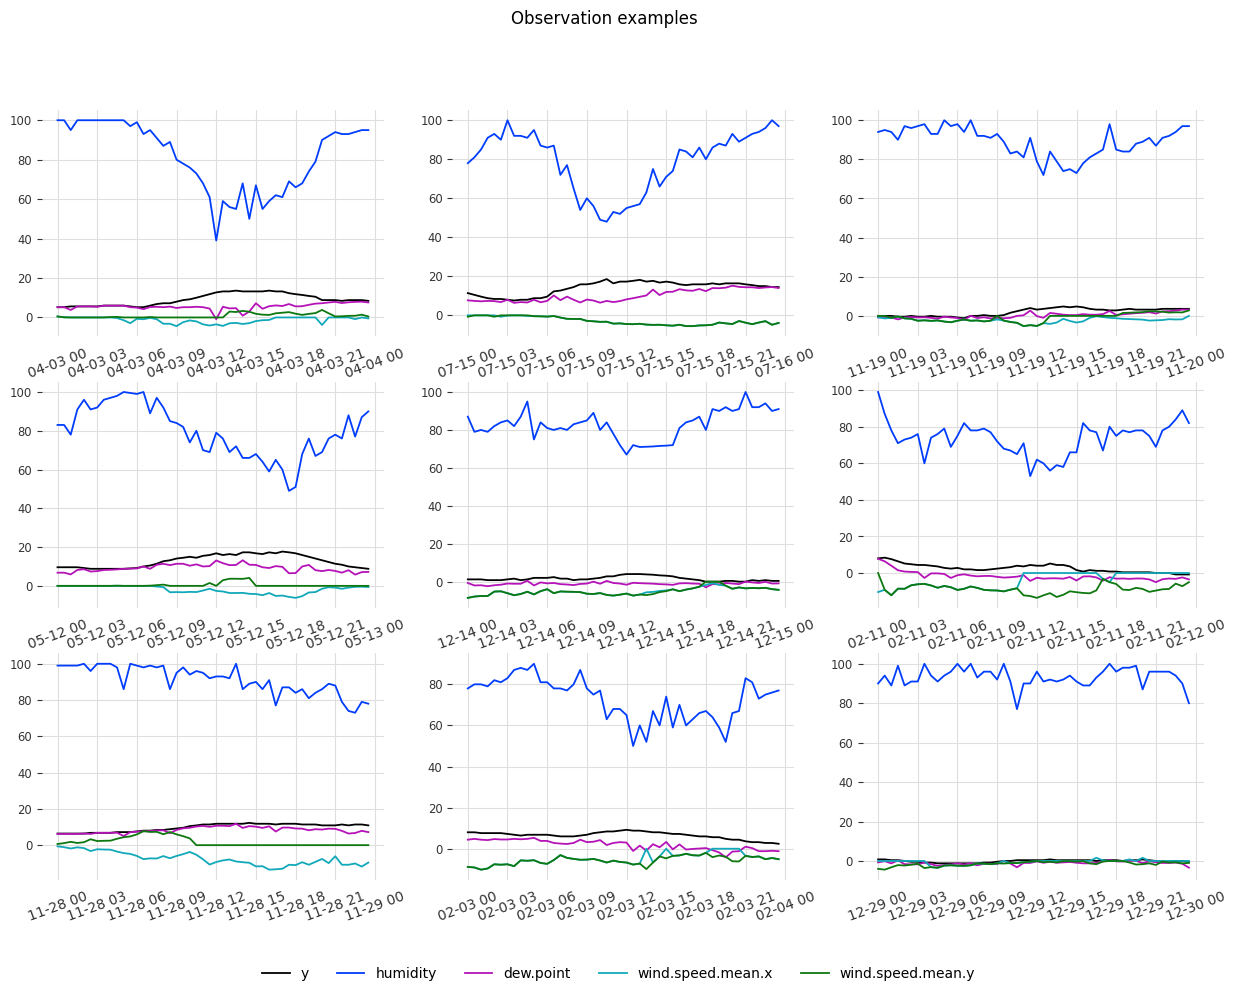

In [5]:
train_df, valid_df, test_df = load_train_valid_test_features('default', location='github')

print('train_df:')
print_df_summary(train_df)
plot_cols = ['y', 'humidity', 'dew.point', 'wind.speed.mean.x',
             'wind.speed.mean.y']  # 'pressure',
plot_observation_examples(train_df, plot_cols)


Unfortunately, `pressure` is not included in the variable plots.  It ranges in value from approx 950 to 1,050 so does not make sense to plot it along with the other features.


---


## VAR Models

Variables modelled:
 * `y` (temperature)
 * `dew.point`
 * `humidity`
 * `pressure`

Exogenous variables included:
 * `day.cos.1`
 * `day.sin.1`
 * `year.cos.1`
 * `year.sin.1`
 * `irradiance`
 * `azimuth_cos`
 * `za_rad`

### Lag selection

Lagged variables up to 96 steps (2 days) were considered.

[AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion), [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) and HQIC are used for lag selection.

,AIC,BIC,FPE,HQIC
0,12.62,12.63,3.040e+05,12.63
1,-0.02283,-0.01766,0.9774,-0.02125
2,-0.3150,-0.3081,0.7298,-0.3129
3,-0.4416,-0.4330,0.6430,-0.4390
4,-0.5225,-0.5122,0.5930,-0.5193
5,-0.5837,-0.5717,0.5578,-0.5801
6,-0.6177,-0.6039,0.5392,-0.6135
7,-0.6372,-0.6217,0.5288,-0.6325
8,-0.6468,-0.6296,0.5237,-0.6415
9,-0.6511,-0.6322,0.5215,-0.6453


{'aic': 96, 'bic': 10, 'hqic': 56, 'fpe': 96}

10


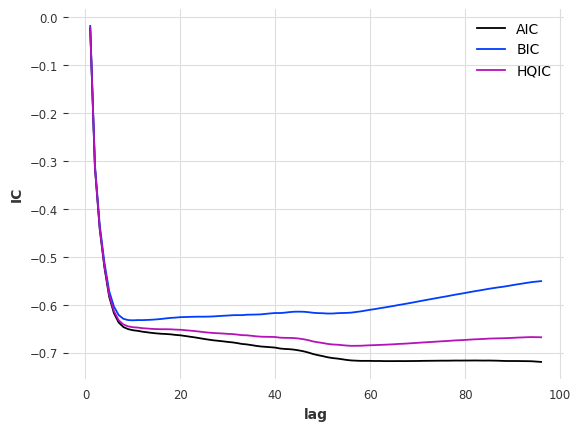

In [7]:
# approx. 5 mins

train_df = train_df.asfreq(freq='30min')
valid_df = valid_df.asfreq(freq='30min')
test_df  = test_df.asfreq(freq='30min')

train_df.dropna(inplace=True)

endo_vars = ['y', 'dew.point', 'humidity', 'pressure']
exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1',
             'irradiance', 'azimuth_cos', 'za_rad']
endo_df = train_df[endo_vars]
exog_df = train_df[exog_vars]

var_model = VAR(endog = endo_df, exog = exog_df)
MAX_LAGS = 96
lag_order_res = var_model.select_order(MAX_LAGS)
display(lag_order_res.summary())
display(lag_order_res.selected_orders)
print(lag_order_res.selected_orders['bic'])

lag_order_table = lag_order_res.summary().data
headers = lag_order_table.pop(0)
lag_order_df = pd.DataFrame(lag_order_table, columns=headers)
lag_order_df.drop('', axis=1, inplace=True)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    lag_order_df = pd.concat([lag_order_df[col].str.replace('*', '').astype(float)
                             for col in lag_order_df], axis=1)

lag_order_df.loc[1:, ['AIC','BIC','HQIC']].plot()
plt.xlabel('lag')
plt.ylabel('IC')
plt.show()

The lowest BIC value occurs at 10 lags.  I'm going to use `maxlags = 10` because that is where decreasing returns set in.

Rebuild VAR model using `maxlags = 10, ic = 'bic'`.

In [15]:


var_fit = var_model.fit(maxlags = 10, ic = 'bic')
print(var_fit.summary())

main_var_col = 'y'
backtest_var = get_var_backtest(var_fit, valid_df, endo_vars, exog_vars, y_col = main_var_col)
hist_comp_var = get_historic_comparison(backtest_var, valid_df, y_col = main_var_col)
summarise_historic_comparison(hist_comp_var, valid_df, y_col = main_var_col)


# metric_cols = ['type', 'method', 'metric', 'horizon', 'value']
# metrics = pd.DataFrame([], columns = metric_cols)
# metrics = update_metrics(metrics, valid_df, 'VAR', var_rolling_cv, var_fit)
## metrics = update_metrics(metrics, test_df, 'VAR', var_rolling_cv, var_fit)
# plot_baseline_metrics(metrics, 'Multivariate Baseline Comparison - 2021 valid data')


# 2019 data
# maxlags = 5
# ...
# h	   rmse	   mae
# 1 	 0.39 	 0.39
# 48 	 2.45 	 1.89

# endo_vars = ['y', 'dew.point', 'pressure', 'humidity',]
# maxlags = 52
# h	   rmse	   mae
# 1 	 0.37 	 0.37
# 48 	 2.253 	 1.784
# maxlags = 52 substantially better than maxlags = 9

# endo_vars = ['y', 'dew.point', 'humidity',]
# maxlags = 52
# h	   rmse	   mae
# 1 	 0.37 	 0.37
# 48 	 2.293 	 1.814
# including pressure is beneficial

# endo_vars = ['y', 'dew.point', 'pressure', 'humidity',]
# exog_vars = ['za_rad', 'irradiance', 'azimuth_cos',]
# maxlags = 51
# h	   rmse	   mae
# 1    0.369 	 0.369
# 48   2.163 	 1.729
# exog_vars is beneficial
# 1 hr 28 mins :-(

# endo_vars = ['y', 'dew.point', 'pressure', 'humidity',]
# exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1',]
# maxlags = 52
# h	   rmse	   mae
# 1    0.37 	 0.37
# 48   2.133 	 1.68
# Sinusoidal terms better than irradiance etc!

# endo_vars = ['y', 'dew.point', 'pressure', 'humidity',]
# exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1', 'irradiance']
# maxlags = 51
# h	   rmse	   mae
# 1    0.369 	 0.369
# 48   2.105 	 1.667
# irradiance worth adding to sinusoidal terms

# endo_vars = ['y', 'dew.point', 'pressure', 'humidity',]
# exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1', 'za_rad']
# maxlags = 51
# h	   rmse	   mae
# 1    0.37 	 0.37
# 48   2.134 	 1.679
# za_rad not as beneficial as irradiance

# endo_vars = ['y', 'dew.point', 'pressure', 'humidity',]
# exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1', 'azimuth_cos']
# maxlags = 51
# h	   rmse	   mae
# 1    0.37 	 0.37
# 48   2.131 	 1.675
# azimuth_cos more beneficial than za_rad

# endo_vars = ['y', 'dew.point', 'pressure', 'humidity',]
# exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1',
#              'irradiance', 'azimuth_cos']
# maxlags = 51
# h	   rmse	   mae
# 1 	 0.368 	 0.368
# 48 	 2.098 	 1.658
# Best model so far

# endo_vars = ['y', 'dew.point', 'pressure', 'humidity',]
# exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1',
#              'irradiance', 'azimuth_cos', 'za_rad']
# maxlags = 51
# h	   rmse	   mae
# 1 	 0.368 	 0.368
# 48 	 2.098 	 1.657
# Marginally better with za_rad

# valid_df
# endo_vars = ['y', 'dew.point', 'pressure', 'humidity',]
# exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1',
#              'irradiance', 'azimuth_cos', 'za_rad']
# maxlags = 51
# h	   rmse	   mae
# 1 	 0.347 	 0.347
# 48 	 2.012 	 1.581
#

# valid_df
# endo_vars = ['y_des', 'dew.point_des', 'pressure', 'humidity',]
# exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1',
#              'irradiance', 'azimuth_cos', 'za_rad']
# maxlags = 53
# h	   rmse	   mae
# 1 	 0.347 	 0.347
# 48 	 2.724   2.132

# valid_df
# endo_vars = ['y_des', 'dew.point_des', 'pressure', 'humidity',]
# exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1',
#              'irradiance', 'azimuth_cos', 'za_rad']
# maxlags = 53
# h	   rmse	   mae
# 1 	 0.357 	 0.357
# 48 	 2.712   2.121

# valid_df
# train_df.loc['2016-01-01':,]
# endo_vars = ['y', 'dew.point', 'pressure', 'humidity',]
# exog_vars = ['day.cos.1', 'day.sin.1', 'year.cos.1', 'year.sin.1',
#              'irradiance', 'azimuth_cos', 'za_rad']
# maxlags = 22
# h	   rmse	   mae
# 1 	 0.352 	 0.352
# 48 	 2.926   2.305
# Backtest RMSE 48th: 2.92592
# Backtest MAE 48th:  2.304481
# Radical decrease in maxlags!
# Not a great model


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 28, Mar, 2024
Time:                     12:12:30
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                  -0.634145
Nobs:                     87158.0    HQIC:                 -0.648491
Log likelihood:          -465960.    FPE:                   0.519547
AIC:                    -0.654798    Det(Omega_mle):        0.518404
--------------------------------------------------------------------
Results for equation y
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -1.413298         0.279297           -5.060           0.000
day.cos.1            -0.517684         0.052599           -9.842           0.000
day.sin.1             0.135958         0.003265           41.639

The updated VAR model shows substantial improvement.  It would benefit from further validation, including residual plots, QQ plots, autocorrelation of residual plots etc

NOTE: Updated VAR validated on 2021 data; initial VAR validated on 2019 data.

---

### Plot model diagnostics


Next, I plot the old and updated VAR models rmse and mae values for forecast horizons up to 48 (24 hours, each horizon step is equivalent to 30 minutes).  

Some points to note regarding diagnostic plots:
 * `plot_horizon_metrics`
   * plot rmse and mae values for each individual step-ahead
 * `check_residuals`
   * observations against predictions
   * residuals over time
   * residual distribution


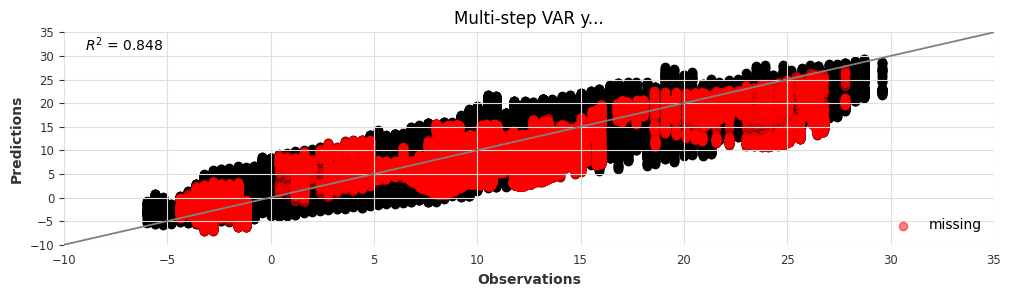

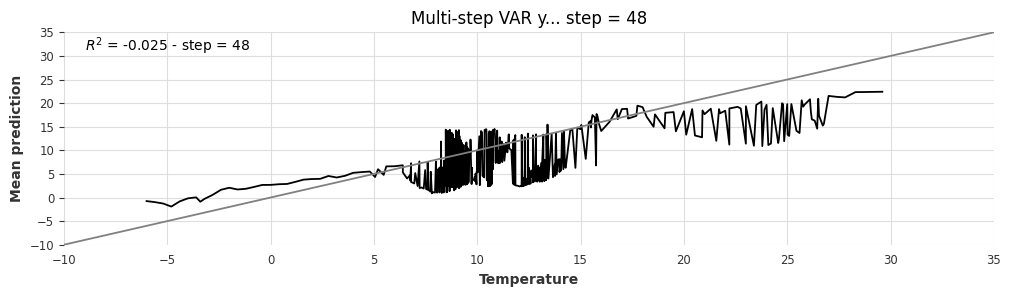

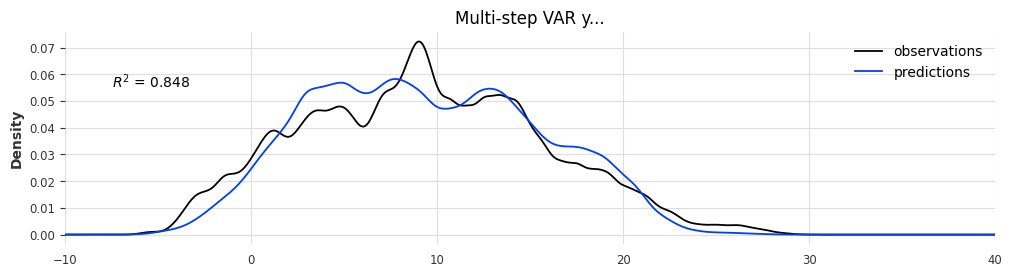

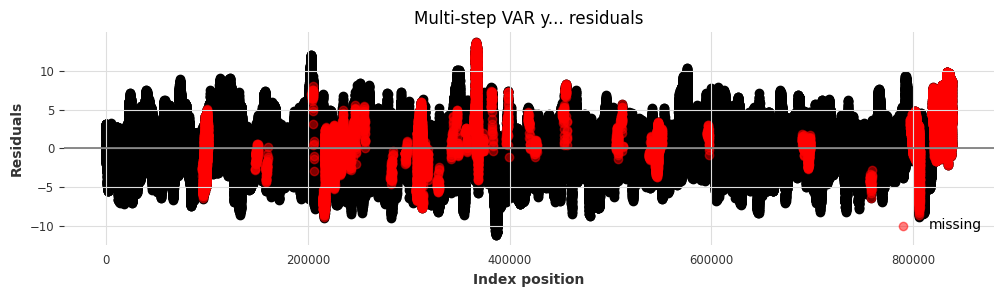

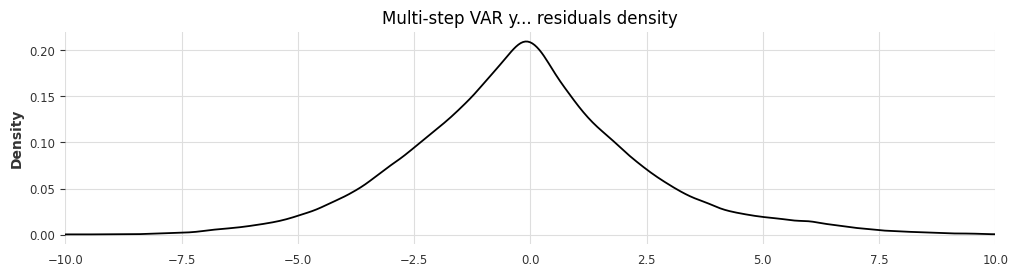

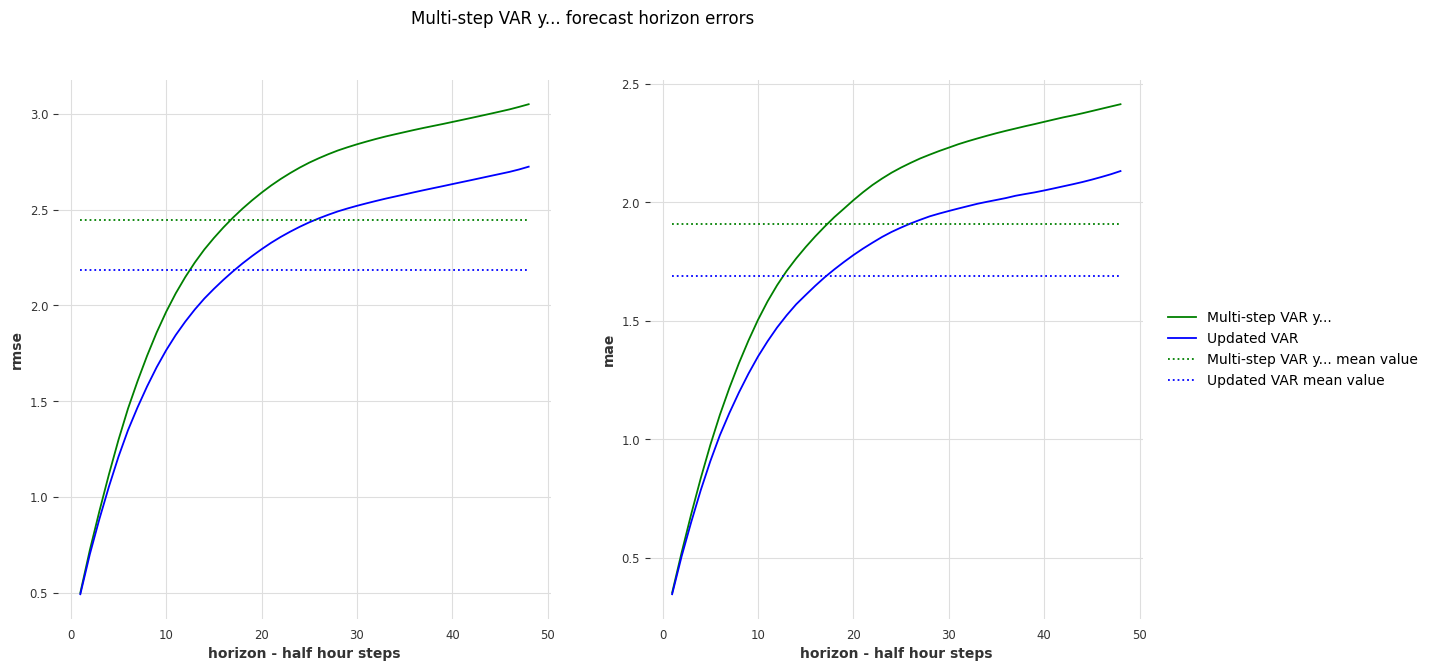

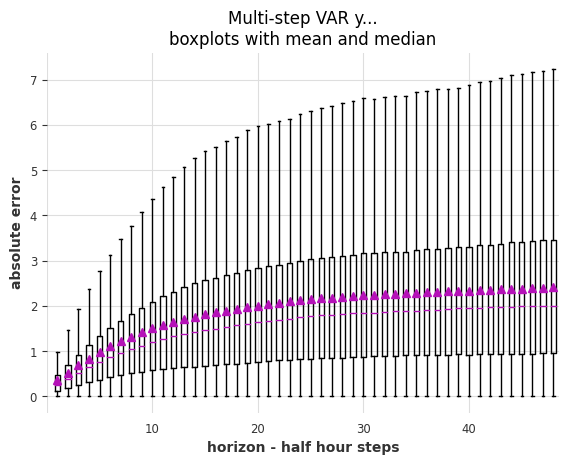

In [16]:
title_var = 'VAR ' + main_var_col + '...'
plot_multistep_diagnostics(hist_comp_var, title_var, y_col = main_var_col)

Updated VAR baseline metric values:

rmse
```
[0.39, 0.52, 0.64, 0.75, 0.86, 0.96, 1.06, 1.15, 1.23,
 1.31, 1.38, 1.45, 1.51, 1.57, 1.63, 1.68, 1.73, 1.77,
 1.81, 1.85, 1.89, 1.92, 1.96, 1.99, 2.02, 2.05, 2.08,
 2.1 , 2.13, 2.15, 2.18, 2.2 , 2.22, 2.24, 2.26, 2.28,
 2.3 , 2.31, 2.33, 2.35, 2.36, 2.38, 2.39, 2.4 , 2.42,
 2.43, 2.44, 2.45]
```

mae
```
[0.39, 0.49, 0.57, 0.66, 0.74, 0.83, 0.91, 0.98, 1.05,
 1.12, 1.18, 1.24, 1.29, 1.34, 1.39, 1.43, 1.47, 1.5 ,
 1.53, 1.56, 1.59, 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72,
 1.73, 1.75, 1.76, 1.77, 1.78, 1.8 , 1.81, 1.82, 1.83,
 1.83, 1.84, 1.85, 1.85, 1.86, 1.86, 1.87, 1.87, 1.88,
 1.88, 1.89, 1.89]
```

---

### Forecast error variance decomposition

The [variance decomposition of forecast errors](https://en.wikipedia.org/wiki/Variance_decomposition_of_forecast_errors) shows the amount of information each variable contributes to the other variables in the vector autoregression.

The forecast errors can be computed via the [statsmodels fevd function](https://www.statsmodels.org/dev/vector_ar.html#forecast-error-variance-decomposition-fevd) up through 48 steps ahead:


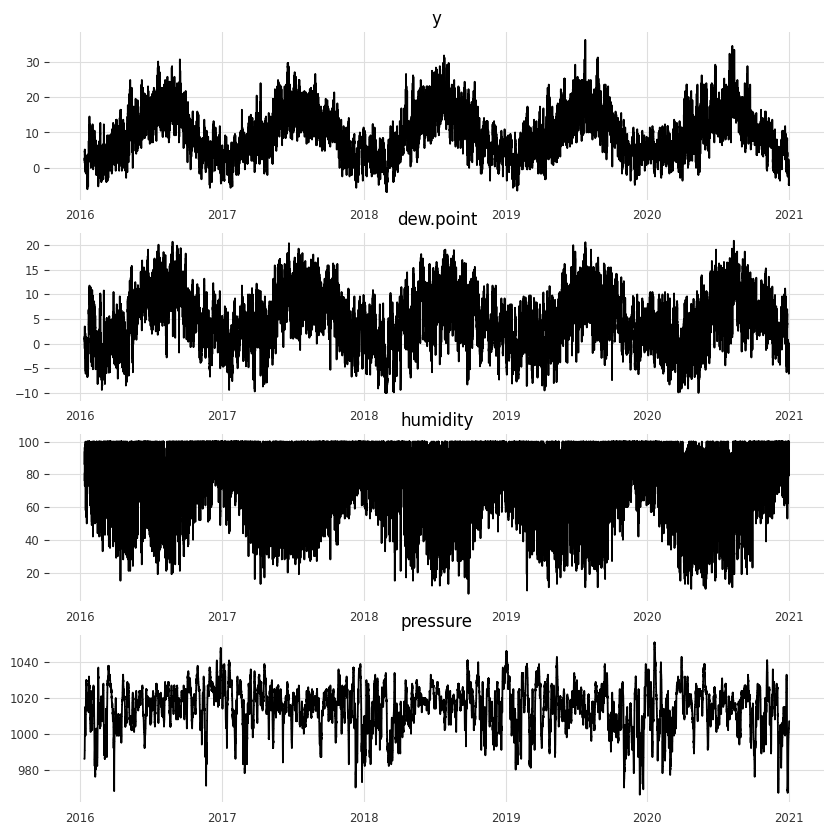

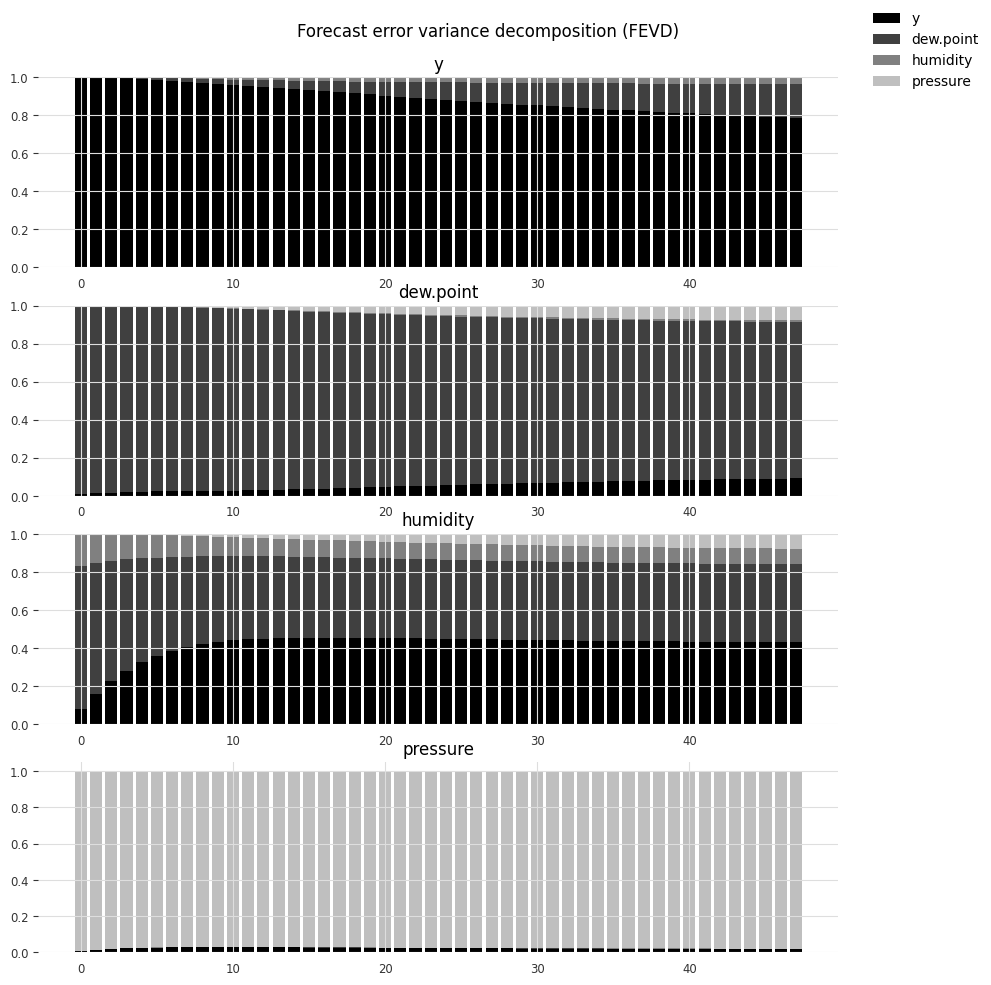

In [17]:
var_fit.plot()
plt.show()

var_fit.fevd(48).plot()
plt.show()

# var_fit.mse(48)
# var_fit.plot_acorr()
# plt.show()

The `pressure` feature does not contribute much to the other features and likewise the other features don't contribute much to `pressure`.

---


## Conclusion

The VAR baseline model has been updated.

 1. What worked
    * more data
    * cleaner data
    * more extensive parameter tuning
    * better diagnostics

 2. What didn't work
    * the forecast error variance decomposition was somewhat insightful
    * but did not change the results in any way

 3. Future work
    * [unobserved components model](https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_structural_harvey_jaeger.html) baseline
    * [NOAA GFS](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast) baseline


---

## Metadata

Python and Jupyter versions plus modules imported and their version strings.
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer.
There are simpler alternatives, such as watermark, but they all require installation.

In [10]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

IPython version:
7.34.0


In [11]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package,
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


<ipython-input-11-f3094ad81fe8>:41: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  reqs.style.hide_index()


name,version
matplotlib,3.7.1
numpy,1.25.2
pandas,1.5.3
scikit-learn,1.2.2
scipy,1.11.4
statsmodels,0.14.1


In [12]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4399.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i

In [13]:
!date

Thu Mar 28 10:59:05 AM UTC 2024


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "gradient_boosting.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}